## Leistungsnachweis Gruppenarbeit
### Gruppe 2 Dimitri Murri, Lukas Barth und Oliver Müller
murridim@students.zhaw.ch, barthluk@students.zhaw.ch, muellol7@students.zhaw.ch

### Inhaltsverzeichnis

### Objective
TEXT TBD

In [1]:
import requests
import os
import shutil
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import time
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.static import players
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from sklearn.feature_selection import mutual_info_regression

#!pip install mysql-connector-python

C:\Users\dimit\AppData\Local\Temp\ipykernel_225856\4268980230.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### (1) Datenerhebung mittels Web Scraping UND Web API

Datenerhebung mittels Web Scraping

In [2]:
# scrape the data, can be only run a few times a day before getting blocked
'''
url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

for year in years:
    url = url_start.format(year)
    
    data = requests.get(url)
    
    with open("mvp/{}.html".format(year), "w+") as f:
        f.write(data.text)
'''

'\nurl_start = "https://www.basketball-reference.com/awards/awards_{}.html"\n\nfor year in years:\n    url = url_start.format(year)\n    \n    data = requests.get(url)\n    \n    with open("mvp/{}.html".format(year), "w+") as f:\n        f.write(data.text)\n'

In [3]:
"""
Reads an HTML file containing MVP data for the year 2022 and extracts the relevant information as an example.

Returns:
    DataFrame: A pandas DataFrame containing the MVP data for the year 2022.
"""

with open("mvp/2022.html") as f:
    page = f.read()

soup = BeautifulSoup(page, 'html.parser')
soup.find('tr', class_="over_header").decompose()

#Check data for 2022
mvp_table = soup.find_all(id="mvp")

mvp_2022 = pd.read_html(str(mvp_table))[0]
mvp_2022.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,1,Nikola Jokić,26,DEN,65.0,875.0,1000,0.875,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
1,2,Joel Embiid,27,PHI,26.0,706.0,1000,0.706,68,33.8,30.6,11.7,4.2,1.1,1.5,0.499,0.371,0.814,12.0,0.252
2,3,Giannis Antetokounmpo,27,MIL,9.0,595.0,1000,0.595,67,32.9,29.9,11.6,5.8,1.1,1.4,0.553,0.293,0.722,12.9,0.281
3,4,Devin Booker,25,PHO,0.0,216.0,1000,0.216,68,34.5,26.8,5.0,4.8,1.1,0.4,0.466,0.383,0.868,7.6,0.156
4,5,Luka Dončić,22,DAL,0.0,146.0,1000,0.146,65,35.4,28.4,9.1,8.7,1.2,0.6,0.457,0.353,0.744,7.6,0.159


Datenerhebung mittels Web API

In [4]:
# Load the data of all players
players_list = players.get_players()

# Beispiel: Spielerdaten für Nikola Jokić
jokic = [player for player in players_list if player['full_name'] == 'Nikola Jokic'][0]
jokic_id = jokic['id']

# Nikola Jokićs Spieler-Log für eine Saison abrufen
log = playergamelog.PlayerGameLog(player_id=jokic_id, season='2023')
df = log.get_data_frames()[0]  # DataFrame mit den Daten

df.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22023,203999,0022301164,"APR 10, 2024",DEN vs. MIN,W,38,16,20,0.800,...,9,11,7,3,0,2,5,41,6,1
1,22023,203999,0022301154,"APR 09, 2024",DEN @ UTA,W,34,12,20,0.600,...,8,13,7,3,1,5,2,28,23,1
2,22023,203999,0022301130,"APR 06, 2024",DEN vs. ATL,W,31,6,13,0.462,...,13,14,11,2,0,4,1,19,19,1
3,22023,203999,0022301114,"APR 04, 2024",DEN @ LAC,L,40,14,24,0.583,...,16,17,10,0,0,5,2,36,12,1
4,22023,203999,0022301099,"APR 02, 2024",DEN vs. SAS,W,38,18,32,0.563,...,12,16,6,1,2,4,2,42,5,1


#### (2) Datenaufbereitung (z.B. Entfernen NAs und Duplikate, Erstellen neuer Variablen, Anreicherung der Daten, ...)

Datenaufbereitung in Dataframe

In [5]:
years = list(range(1990,2023))
#years = [ 2016]

dfs = []
for year in years:
    with open("mvp/{}.html".format(year)) as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="over_header").decompose()
    mvp_table = soup.find_all(id="mvp")[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df["Year"] = year
    dfs.append(mvp_df)

mvps = pd.concat(dfs)

mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Magic Johnson,30,LAL,27.0,636.0,920,0.691,79,37.2,...,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990
1,2,Charles Barkley,26,PHI,38.0,614.0,920,0.667,79,39.1,...,11.5,3.9,1.9,0.6,0.600,0.217,0.749,17.3,0.269,1990
2,3,Michael Jordan,26,CHI,21.0,564.0,920,0.613,82,39.0,...,6.9,6.3,2.8,0.7,0.526,0.376,0.848,19.0,0.285,1990
3,4,Karl Malone,26,UTA,2.0,214.0,920,0.233,82,38.1,...,11.1,2.8,1.5,0.6,0.562,0.372,0.762,15.9,0.245,1990
4,5,Patrick Ewing,27,NYK,1.0,162.0,920,0.176,82,38.6,...,10.9,2.2,1.0,4.0,0.551,0.250,0.775,13.5,0.205,1990


#### NANs prüfen

In [54]:
print(mvps.isna().sum())

Rank               0
Player             0
Age                0
Tm                 0
First              0
Pts Won            0
Pts Max            0
Share              0
G                  0
MP                 0
PTS                0
TRB                0
AST                0
STL                0
BLK                0
FG%                0
3P%               11
FT%                0
WS                 0
Year               0
MVP Share          0
Nationality        0
Position           0
Weight_kg          2
Height_cm          2
DRAFT_NUMBER       5
FGA                0
FGM                0
FTA                0
FTM                0
TOV                0
3PM                0
MIN                0
DREB               0
OREB               0
Simplified_BPM     0
FT_Miss            0
FG_Miss            0
PER                0
MVP                0
dtype: int64


Anhand der Stichprobe von Gobert prüfen ob NAN korrekt ist.
Gemäss API hat Gobert in der Saison keinen einzigen 3-Punkte-Wurf gemacht, was mit den Daten aus der MVP-Tabelle übereinstimmt. Deshalb gehen wir davon aus, dass die Nullwerte in der MVP-Tabelle korrekt sind und keine fehlenden Werte darstellen

In [7]:
# Finde die Zeilen, in denen '3P%' Null ist
null_3p_pct_rows = mvps[mvps['3P%'].isnull()]

# Die Spieler, die in diesen Zeilen aufgeführt sind, haben effektiv keinen Wurf ausserhalb der 3-Punkte-Linie gemacht 
print(null_3p_pct_rows)

# Prüfen  ob die Daten aus der API dasselbe aussagen anhand Stichprobe von Goberz
gobert = [player for player in players_list if player['full_name'] == 'Rudy Gobert'][0]
gobert_id = gobert['id']

log_gobert_19 = playergamelog.PlayerGameLog(player_id=gobert_id, season='2018')
df_gobert_19 = log_gobert_19.get_data_frames()[0]  # DataFrame mit den Daten

print(df_gobert_19)

total_3pa = df_gobert_19['FG3A'].sum()  # Gesamtanzahl der Dreipunktewurfversuche
total_3pm = df_gobert_19['FG3M'].sum()  # Gesamtanzahl der getroffenen Dreipunktewürfe
gobert_3p_pct = (total_3pm / total_3pa) if total_3pa > 0 else 0

print(f"Rudy Gobert's career 3P%: {gobert_3p_pct:.3f}")

   Rank            Player  Age   Tm  First  Pts Won  Pts Max  Share   G    MP  \
12  13T   Dikembe Mutombo   30  ATL    0.0      4.0     1150  0.003  80  37.2   
3     4  Shaquille O'Neal   25  LAL    1.0    311.0     1160  0.268  60  36.3   
15  15T     Anthony Mason   34  MIA    0.0      1.0     1240  0.001  80  40.7   
16  16T       Elton Brand   22  LAC    0.0      1.0     1260  0.001  80  37.8   
4     5  Shaquille O'Neal   30  LAL    3.0    126.0     1190  0.106  67  37.8   
5     6  Shaquille O'Neal   31  LAL    0.0    178.0     1230  0.145  67  36.8   
1     2  Shaquille O'Neal   32  MIA   58.0   1032.0     1270  0.813  73  34.1   
13  14T        P.J. Brown   35  NOH    0.0      1.0     1270  0.001  82  34.4   
8    9T     Carlos Boozer   25  UTA    0.0      7.0     1290  0.005  74  34.6   
11  12T  Shaquille O'Neal   34  MIA    0.0      3.0     1290  0.002  40  28.4   
10  11T       Rudy Gobert   26  UTA    0.0      1.0     1010  0.001  81  31.8   

    ...  AST  STL  BLK    F

#### Anreicherung der Daten aus dem WebScrping mit den Daten aus der API und Erstellung neuer Variablen
Einige relevanten Daten fehlen aus den gescrapten Daten. Da wir aber als Basis die Daten aus dem scraping verwenden wollten (da in der Realität nicht immer eine vollständige API verfügbar ist), haben wir die fehlenden Attribute anhand der nba_api ergänzt.
Dazu gehöhren Daten den Spielern selbst sowieso ihre sog. Stats. 

In [8]:
mvps.reset_index(drop=True, inplace=True)

mvps['Nationality'] = ''
mvps['Position'] = ''
mvps['Weight_kg'] = ''
mvps['Height_cm'] = ''
mvps['DRAFT_NUMBER'] = ''
mvps['FGA'] = None
mvps['FGM'] = None
mvps['FTA'] = None
mvps['FTM'] = None
mvps['TOV'] = None
mvps['3PM'] = None
mvps['MIN'] = None
mvps['DREB'] = None
mvps['OREB'] = None 

players_dict = players.get_players()

def replace_special_characters(name):
    replacements = {'ć': 'c', 'ó': 'o', 'č': 'c'}
    for original, replacement in replacements.items():
        name = name.replace(original, replacement)
    return name

# Update this dictionary for any known exceptions
# Smith is spelled differently in the API and the MVP data
known_exceptions = {
    "Steve Smith": "Steven Smith"
}

def height_to_cm(height_str):
    if pd.isna(height_str) or isinstance(height_str, float):
        return None
    try:
        feet, inches = height_str.split("-")  # Change the split character from "'" to "-"
        feet = int(feet)
        inches = int(inches)  # Since the inches part doesn't have any quotes to remove, no need for replace
        return (feet * 12 + inches) * 2.54
    except ValueError:
        # Handle the case where height is not in the "X-Y" format
        return None

def get_season_string(year):
    start_year = int(year)
    end_year = start_year + 1
    return f"{start_year}-{str(end_year)[2:]}"

def get_player_info(full_name, year):
    # Check if the name is a known exception and replace accordingly.
    full_name = known_exceptions.get(full_name, full_name)
    full_name = replace_special_characters(full_name)
    
    player_list = [player for player in players_dict if player['full_name'].lower() == full_name.lower()]
    
    for player in player_list:
        player_id = player['id']
        player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id).get_normalized_dict()
        player_info_data = player_info['CommonPlayerInfo'][0]
        if adjusted_year >= int(player_info_data['FROM_YEAR']) and adjusted_year <= int(player_info_data['TO_YEAR']):
            return (player_info_data['COUNTRY'], 
                    player_info_data['POSITION'], 
                    player_info_data['WEIGHT'],
                    player_info_data['HEIGHT'], 
                    player_info_data['DRAFT_NUMBER'])
    
    
def get_player_stats(full_name, year):
    # Check if the name is a known exception and replace accordingly.
    full_name = known_exceptions.get(full_name, full_name)
    full_name = replace_special_characters(full_name)
    season_id = get_season_string(year)
    player_list = [player for player in players_dict if player['full_name'].lower() == full_name.lower()]
    for player in player_list:
        player_id = player['id']
        player_info_stats = playercareerstats.PlayerCareerStats(player_id=player_id).get_normalized_dict()
        player_info_stats_data = player_info_stats['SeasonTotalsRegularSeason'][0]
        
        for season_stats in player_info_stats['SeasonTotalsRegularSeason']:
            if season_stats['SEASON_ID'] == season_id:
                return (season_stats['FGA'], 
                        season_stats['FGM'], 
                        season_stats['FTA'], 
                        season_stats['FTM'], 
                        season_stats['TOV'], 
                        season_stats['FG3M'], 
                        season_stats['MIN'], 
                        season_stats['DREB'], 
                        season_stats['OREB'])
    
    print(f"No stats found for {full_name} in season {season_id}")
        

for index, row in mvps.iterrows():
    #if index >= 20:
    #    break
    adjusted_year = row['Year'] - 1
    nationality, position, weight, height, draft_number = get_player_info(row['Player'], adjusted_year)

    if nationality and position:
        mvps.at[index, 'Nationality'] = nationality
        mvps.at[index, 'Position'] = position
        mvps.at[index, 'Weight_kg'] = weight
        mvps.at[index, 'Height_cm'] = height
        mvps.at[index, 'DRAFT_NUMBER'] = draft_number
        
    else:
        print(f"No data found for player: {row['Player']} in year {row['Year']}")
        
    FGA, FGM, FTA, FTM, TOV, threePM, MIN, DREB, OREB= get_player_stats(row['Player'], adjusted_year)
    if FGA and FGM and FTA and FTM and TOV:
        mvps.at[index, 'FGA'] = int(FGA)
        mvps.at[index, 'FGM'] = int(FGM)
        mvps.at[index, 'FTA'] = int(FTA)
        mvps.at[index, 'FTM'] = int(FTM)
        mvps.at[index, 'TOV'] = int(TOV)
        mvps.at[index, '3PM'] = int(threePM)
        mvps.at[index, 'MIN'] = int(MIN)
        mvps.at[index, 'DREB'] = int(DREB)
        mvps.at[index, 'OREB'] = int(OREB)
    else:
        print(f"No stats found for player: {row['Player']} in year {row['Year']}")

# Convert height to centimeters
mvps['Height_cm'] = mvps['Height_cm'].apply(height_to_cm)

# Convert weight from pounds to kilograms
mvps['Weight_kg'] = pd.to_numeric(mvps['Weight_kg'], errors='coerce') / 2.20462

# Convert draft number to numeric type
mvps['DRAFT_NUMBER'] = pd.to_numeric(mvps['DRAFT_NUMBER'], errors='coerce').astype(pd.Int32Dtype())

# Set the proper data types for other columns
mvps['Nationality'] = mvps['Nationality'].astype('string')
mvps['Position'] = mvps['Position'].astype('string')

mvps['FGA'] = pd.to_numeric(mvps['FGA'], errors='coerce')
mvps['FGM'] = pd.to_numeric(mvps['FGM'], errors='coerce')
mvps['FTA'] = pd.to_numeric(mvps['FTA'], errors='coerce')
mvps['FTM'] = pd.to_numeric(mvps['FTM'], errors='coerce')
mvps['TOV'] = pd.to_numeric(mvps['TOV'], errors='coerce')
mvps['3PM'] = pd.to_numeric(mvps['3PM'], errors='coerce')
mvps['MIN'] = pd.to_numeric(mvps['MIN'], errors='coerce')
mvps['DREB'] = pd.to_numeric(mvps['DREB'], errors='coerce')
mvps['OREB'] = pd.to_numeric(mvps['OREB'], errors='coerce')

mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,DRAFT_NUMBER,FGA,FGM,FTA,FTM,TOV,3PM,MIN,DREB,OREB
0,1,Magic Johnson,30,LAL,27.0,636.0,920,0.691,79,37.2,...,1,1138,546,637,567,289,106,2937,394,128
1,2,Charles Barkley,26,PHI,38.0,614.0,920,0.667,79,39.1,...,5,1177,706,744,557,243,20,3085,548,361
2,3,Michael Jordan,26,CHI,21.0,564.0,920,0.613,82,39.0,...,3,1964,1034,699,593,247,92,3197,422,143
3,4,Karl Malone,26,UTA,2.0,214.0,920,0.233,82,38.1,...,13,1627,914,913,696,304,16,3122,679,232
4,5,Patrick Ewing,27,NYK,1.0,162.0,920,0.176,82,38.6,...,1,1673,922,648,502,278,1,3165,658,235


Advanced Stats berechnen wie zum Beispiel Box Plus/minus (BPM) und PER um später eine bessere Prediction machen zu können. Es gibt APIs welche auch diese Infos direkt hätten, hier wurde eine eigene Berechnung bevorzugt.

Für BPM daran orientiert: https://basketballstat.home.blog/2019/08/27/box-plus-minus-bpm/ 
Quelle für PER: https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess

In [65]:
mvps['Simplified_BPM'] = ((mvps['PTS'] + 0.5 * mvps['TRB'] + mvps['AST'] + 2 * (mvps['STL'] + mvps['BLK'])
                          - (mvps['FGA'] - mvps['FGM']) - 0.5 * (mvps['FTA'] - mvps['FTM']) - mvps['TOV']) / mvps['MP']) * -1

mvps['FT_Miss'] = mvps['FTA'] - mvps['FTM']
mvps['FG_Miss'] = mvps['FGA'] - mvps['FGM']
mvps['FT_Miss'] = pd.to_numeric(mvps['OREB'], errors='coerce')
mvps['FG_Miss'] = pd.to_numeric(mvps['DREB'], errors='coerce')

mvps['PER'] = (mvps['FGM'] * 85.910 + mvps['STL'] * 53.897 + mvps['STL'] * 51.757 + mvps['FTM'] * 46.845 + mvps['BLK'] * 39.190 + 
       mvps['OREB'] * 39.190 + mvps['AST'] * 34.677 + mvps['DREB'] * 14.707 - 
       mvps['FT_Miss'] * 20.091 - mvps['FG_Miss'] * 39.190 - mvps['TOV'] * 53.897) / mvps['MIN']

mvps.head()

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TOV,3PM,MIN,DREB,OREB,Simplified_BPM,FT_Miss,FG_Miss,PER,MVP
0,1,Magic Johnson,30,LAL,27.0,636.0,920,0.691,79,37.2,...,289,106,2937,394,128,23.513441,128,394,17.461418,1
1,10,Larry Bird,33,BOS,0.0,5.0,920,0.005,75,39.3,...,243,65,2944,622,90,25.777354,90,622,17.139875,0
2,11,Buck Williams,29,POR,0.0,5.0,920,0.005,82,34.2,...,168,0,2801,550,250,15.979532,250,550,11.202878,0
3,12,Clyde Drexler,27,POR,0.0,3.0,920,0.003,73,36.8,...,191,30,2683,299,208,24.142663,208,299,22.348218,0
4,13,Joe Dumars,26,DET,0.0,1.0,920,0.001,75,34.4,...,145,22,2578,152,60,19.936047,60,152,18.393772,0


### (3) Speichern der Daten in einer Database wie MySQL oder PostgreSQL sowie SQL Abfragen aus dieser

In [10]:
db = pymysql.connect(host="secondtest.cfis62ku07hb.eu-central-1.rds.amazonaws.com", user="admin", password="12345678")

In [11]:
"""
This code selects the version of the database being used to show that the connection is working.
"""

cursor = db.cursor()
cursor.execute("select version()")


1

In [12]:
"""
Creates a database named 'ads_project_group2' if it doesn't already exist.
"""
sql = '''create database if not exists ads_project_group2;'''
cursor.execute(sql)
cursor.connection.commit()


In [13]:
sql = '''use ads_project_group2'''
cursor.execute(sql)

0

In [14]:
# CREATE TABLE Anweisung für die Tabelle 'player_game_log'

create_table_query = '''
CREATE TABLE IF NOT EXISTS player_game_log (
    Player_ID INT,
    Season VARCHAR(7),
    Game_ID VARCHAR(15),
    Game_Date DATE,
    MATCHUP VARCHAR(15),
    WL CHAR(1),
    MIN INT,
    FGM INT,
    FGA INT,
    FG_PCT FLOAT,
    FG3M INT,
    FG3A INT,
    FG3_PCT FLOAT,
    FTM INT,
    FTA INT,
    FT_PCT FLOAT,
    OREB INT,
    DREB INT,
    REB INT,
    AST INT,
    STL INT,
    BLK INT,
    TOV INT,
    PF INT,
    PTS INT,
    PLUS_MINUS INT,
    VIDEO_AVAILABLE TINYINT,
    AST_TO_TOV_RATIO FLOAT
);
'''
#Added the column 'AST_TO_TOV_RATIO' to the table

cursor.execute(create_table_query)

# Commit (Bestätigen) Sie die Änderungen, falls erforderlich
db.commit()
#'''


In [15]:
# Execute SQL query to show tables and check if it worked
sql = '''show tables'''
cursor.execute(sql)
cursor.fetchall()

(('player_game_log',),)

In [16]:
# INSERT INTO Anweisung vorbereiten
def insert_player_game_log(player_game_log_df, player_id):

    # SQL insert statement
    insert_stmt = (
        "INSERT INTO player_game_log (Player_ID, Season, Game_ID, Game_Date, MATCHUP, WL, MIN, FGM, FGA, FG_PCT, FG3M, FG3A, FG3_PCT, FTM, FTA, FT_PCT, OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS, PLUS_MINUS, VIDEO_AVAILABLE, AST_TO_TOV_RATIO) "
        "VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
        )
        
    # Insert data into the table
    for index, row in player_game_log_df.iterrows():
        data = (
            row['Player_ID'],
            row['SEASON_ID'],  # Make sure this column name matches the one in your DataFrame
            row['Game_ID'],
            row['GAME_DATE'],
            row['MATCHUP'],
            row['WL'],
            row['MIN'],
            row['FGM'],
            row['FGA'],
            row['FG_PCT'],
            row['FG3M'],
            row['FG3A'],
            row['FG3_PCT'],
            row['FTM'],
            row['FTA'],
            row['FT_PCT'],
            row['OREB'],
            row['DREB'],
            row['REB'],
            row['AST'],
            row['STL'],
            row['BLK'],
            row['TOV'],
            row['PF'],
            row['PTS'],
            row['PLUS_MINUS'],
            row['VIDEO_AVAILABLE'],
            row['AST_TO_TOV_RATIO']
    
        )
        cursor.execute(insert_stmt, data)
        
        # Commit the transaction
    db.commit()
    print(cursor.rowcount, "records inserted successfully into player_game_log table")
        

# Add assist to turnover ratio 
df['AST_TO_TOV_RATIO'] = df.apply(lambda x: x['AST'] / x['TOV'] if x['TOV'] > 0 else 0, axis=1)

#Game date muss formatiert werden, so dass es in der DB korrekt angezeigt wird und nicht als 0000-00-00
df['GAME_DATE'] = df['GAME_DATE'].astype(str)
correct_date_format = df['GAME_DATE'].str.match(r'^\d{4}-\d{2}-\d{2}$')
incorrect_dates = df[~correct_date_format]
print(incorrect_dates)
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], errors='coerce')

# Insert the data into SQL
insert_player_game_log(df, jokic_id)


   SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0      22023     203999  0022301164  APR 10, 2024  DEN vs. MIN  W   38   16   
1      22023     203999  0022301154  APR 09, 2024    DEN @ UTA  W   34   12   
2      22023     203999  0022301130  APR 06, 2024  DEN vs. ATL  W   31    6   
3      22023     203999  0022301114  APR 04, 2024    DEN @ LAC  L   40   14   
4      22023     203999  0022301099  APR 02, 2024  DEN vs. SAS  W   38   18   
..       ...        ...         ...           ...          ... ..  ...  ...   
72     22023     203999  0022300123  NOV 01, 2023    DEN @ MIN  L   30   11   
73     22023     203999  0022300110  OCT 30, 2023  DEN vs. UTA  W   35   12   
74     22023     203999  0022300095  OCT 29, 2023    DEN @ OKC  W   30   12   
75     22023     203999  0022300078  OCT 27, 2023    DEN @ MEM  W   35    8   
76     22023     203999  0022300061  OCT 24, 2023  DEN vs. LAL  W   36   12   

    FGA  FG_PCT  ...  REB  AST  STL  BLK  TOV  PF  

C:\Users\dimit\AppData\Local\Temp\ipykernel_225856\3698845469.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], errors='coerce')


1 records inserted successfully into player_game_log table


In [17]:
cursor.execute("SELECT * FROM player_game_log")

# Hole alle Zeilen der Abfrage
rows = cursor.fetchall()

# Erstelle einen DataFrame aus den Abfrageergebnissen 
columns = [desc[0] for desc in cursor.description]
all_data_jokic_df = pd.DataFrame(rows, columns=columns)

# Zeige den DataFrame an
all_data_jokic_df

,Player_ID,Season,Game_ID,Game_Date,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,AST_TO_TOV_RATIO
0,203999,22023,0022301164,2024-04-10,DEN vs. MIN,W,38,16,20,0.800,...,11,7,3,0,2,5,41,6,1,3.500000
1,203999,22023,0022301154,2024-04-09,DEN @ UTA,W,34,12,20,0.600,...,13,7,3,1,5,2,28,23,1,1.400000
2,203999,22023,0022301130,2024-04-06,DEN vs. ATL,W,31,6,13,0.462,...,14,11,2,0,4,1,19,19,1,2.750000
3,203999,22023,0022301114,2024-04-04,DEN @ LAC,L,40,14,24,0.583,...,17,10,0,0,5,2,36,12,1,2.000000
4,203999,22023,0022301099,2024-04-02,DEN vs. SAS,W,38,18,32,0.563,...,16,6,1,2,4,2,42,5,1,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,203999,22023,0022300123,2023-11-01,DEN @ MIN,L,30,11,23,0.478,...,10,3,0,0,5,0,25,-19,1,0.600000
73,203999,22023,0022300110,2023-10-30,DEN vs. UTA,W,35,12,16,0.750,...,10,11,0,2,1,3,27,13,1,11.000000
74,203999,22023,0022300095,2023-10-29,DEN @ OKC,W,30,12,16,0.750,...,14,5,0,0,4,3,28,21,1,1.250000
75,203999,22023,0022300078,2023-10-27,DEN @ MEM,W,35,8,14,0.571,...,12,7,1,1,9,1,22,6,1,0.777778


In [18]:
query = "SELECT * FROM player_game_log WHERE PTS >= 10 AND REB >= 10 AND AST >= 10"
cursor.execute(query)

# Fetch all rows of the query
rows = cursor.fetchall()

# Create a DataFrame from the query results
columns = [desc[0] for desc in cursor.description]
triple_doubles_df = pd.DataFrame(rows, columns=columns)

# Show the DataFrame
triple_doubles_df


,Player_ID,Season,Game_ID,Game_Date,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,AST_TO_TOV_RATIO
0,203999,22023,0022301130,2024-04-06,DEN vs. ATL,W,31,6,13,0.462,...,14,11,2,0,4,1,19,19,1,2.75000
1,203999,22023,0022301114,2024-04-04,DEN @ LAC,L,40,14,24,0.583,...,17,10,0,0,5,2,36,12,1,2.00000
2,203999,22023,0022301077,2024-03-31,DEN vs. CLE,W,35,11,18,0.611,...,18,16,1,0,3,2,26,37,1,5.33333
3,203999,22023,0022301009,2024-03-21,DEN vs. NYK,W,39,12,23,0.522,...,14,11,1,0,1,1,30,30,1,11.00000
4,203999,22023,0022300937,2024-03-11,DEN vs. TOR,W,38,14,26,0.538,...,17,12,6,2,2,3,35,13,1,6.00000
5,203999,22023,0022300906,2024-03-07,DEN vs. BOS,W,39,11,19,0.579,...,12,11,2,0,0,1,32,9,1,0.00000
6,203999,22023,0022300847,2024-02-28,DEN vs. SAC,W,32,5,9,0.556,...,14,11,3,1,2,3,14,37,1,5.50000
7,203999,22023,0022300824,2024-02-25,DEN @ GSW,W,37,13,24,0.542,...,16,16,4,1,2,3,32,20,1,8.00000
8,203999,22023,0022300812,2024-02-23,DEN @ POR,W,35,12,17,0.706,...,15,14,2,1,2,4,29,24,1,7.00000
9,203999,22023,0022300800,2024-02-22,DEN vs. WAS,W,31,10,10,1.000,...,19,15,1,0,3,3,21,23,1,5.00000


### (4) Umfangreiche Explorative Datenanalyse (EDA)

Bei der Analyse ist aufgefallen, dass es bei den Ranks oft "ties" gibt, so können mehrere Spieler z.B. Rank 10T haben.
Dies wird unterhalb bereinigt und bei einem Unentschieden wird der Rang der darauffolgenden erhäht. Da auf dem ersten Platz seit 1990 noch nie ein unentschieden war, hat dies keinen Einfluss auf das neue Flag MVP, welches zeigt, ob der Spieler MVP wurde oder nicht.

In [19]:
print(mvps.dtypes)

mvps = mvps.sort_values(by=['Year', 'Rank'])

# Function to adjust ranks within each year
#Since there was never a tie on first place, we just increment the rank by 1 for each tie, so that the ranks are unique
def adjust_ranks(df):
    df = df.copy()  # Make a copy to avoid changing the original DataFrame
    ranks = df['Rank'].apply(str).tolist()  # Ensure all ranks are strings for manipulation
    
    # Convert all rank entries into integers, stripping the 'T' if it exists
    numeric_ranks = [int(rank.replace('T', '')) for rank in ranks]
    
    # Create a dictionary to count occurrences of each rank
    rank_count = {}
    for rank in numeric_ranks:
        if rank in rank_count:
            rank_count[rank] += 1
        else:
            rank_count[rank] = 1
    
    # Adjust ranks based on the number of previous occurrences
    adjusted_ranks = []
    occurrence_tracker = {}
    for rank in numeric_ranks:
        if rank not in occurrence_tracker:
            occurrence_tracker[rank] = 0
        
        # If the rank count is more than one (i.e., there are ties), calculate new rank
        if rank_count[rank] > 1:
            new_rank = rank + occurrence_tracker[rank]
            adjusted_ranks.append(f"{new_rank}T")  # Append 'T' to indicate it was a tie
        else:
            adjusted_ranks.append(str(rank))
        
        # Update occurrence for this rank
        occurrence_tracker[rank] += 1
    
    # Assign the adjusted ranks back to the DataFrame
    df['Rank'] = adjusted_ranks
    return df

# Apply the function to each year group
mvps = mvps.groupby('Year').apply(adjust_ranks).reset_index(drop=True)

mvps['Rank'] = mvps['Rank'].str.replace('T', '')

# Convert 'Rank' to integers
mvps['Rank'] = pd.to_numeric(mvps['Rank'], errors='coerce').astype('Int32')

# create mvp won column
mvps['MVP'] = mvps['Rank'].apply(lambda rank: 1 if rank == 1 else 0)

Rank                      object
Player                    object
Age                        int64
Tm                        object
First                    float64
Pts Won                  float64
Pts Max                    int64
Share                    float64
G                          int64
MP                       float64
PTS                      float64
TRB                      float64
AST                      float64
STL                      float64
BLK                      float64
FG%                      float64
3P%                      float64
FT%                      float64
WS                       float64
WS/48                    float64
Year                       int64
MVP Share                float64
Nationality       string[python]
Position          string[python]
Weight_kg                float64
Height_cm                float64
DRAFT_NUMBER               Int32
FGA                        int64
FGM                        int64
FTA                        int64
FTM       

In [67]:
print(mvps.describe())


          Rank         Age       First      Pts Won      Pts Max       Share  \
count    500.0  500.000000  500.000000   500.000000   500.000000  500.000000   
mean     8.334   27.746000    7.536000   195.892000  1143.100000    0.171586   
std    4.79546    3.862035   22.543316   313.856145   117.436675    0.272690   
min        1.0   19.000000    0.000000     1.000000   920.000000    0.001000   
25%        4.0   25.000000    0.000000     4.000000  1010.000000    0.003000   
50%        8.0   27.500000    0.000000    26.000000  1190.000000    0.024500   
75%       12.0   30.000000    1.000000   256.750000  1240.000000    0.231500   
max       21.0   38.000000  131.000000  1310.000000  1310.000000    1.000000   

                G          MP         PTS         TRB  ...         TOV  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean    72.976000   36.392800   22.452400    7.533200  ...  206.196000   
std     10.474868    2.999337    5.172667    3.282567  ..

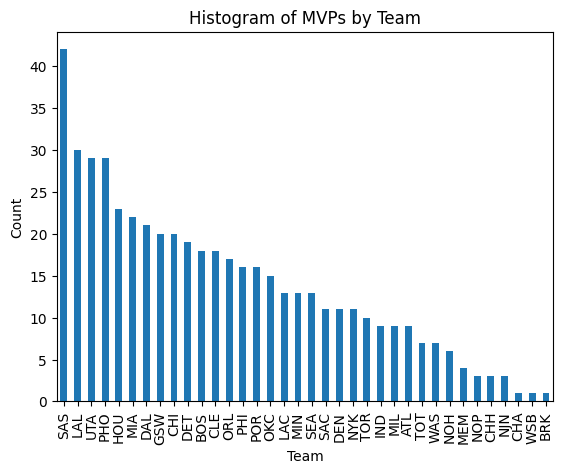

In [68]:
mvps['Tm'].value_counts().plot(kind='bar')

plt.xlabel('Team')
plt.ylabel('Count')
plt.title('Histogram of MVPs by Team')

plt.show()

Am meisten MVP-Votes erhielten in den letzten rund 30 Jahren Spieler aus San Antonio.

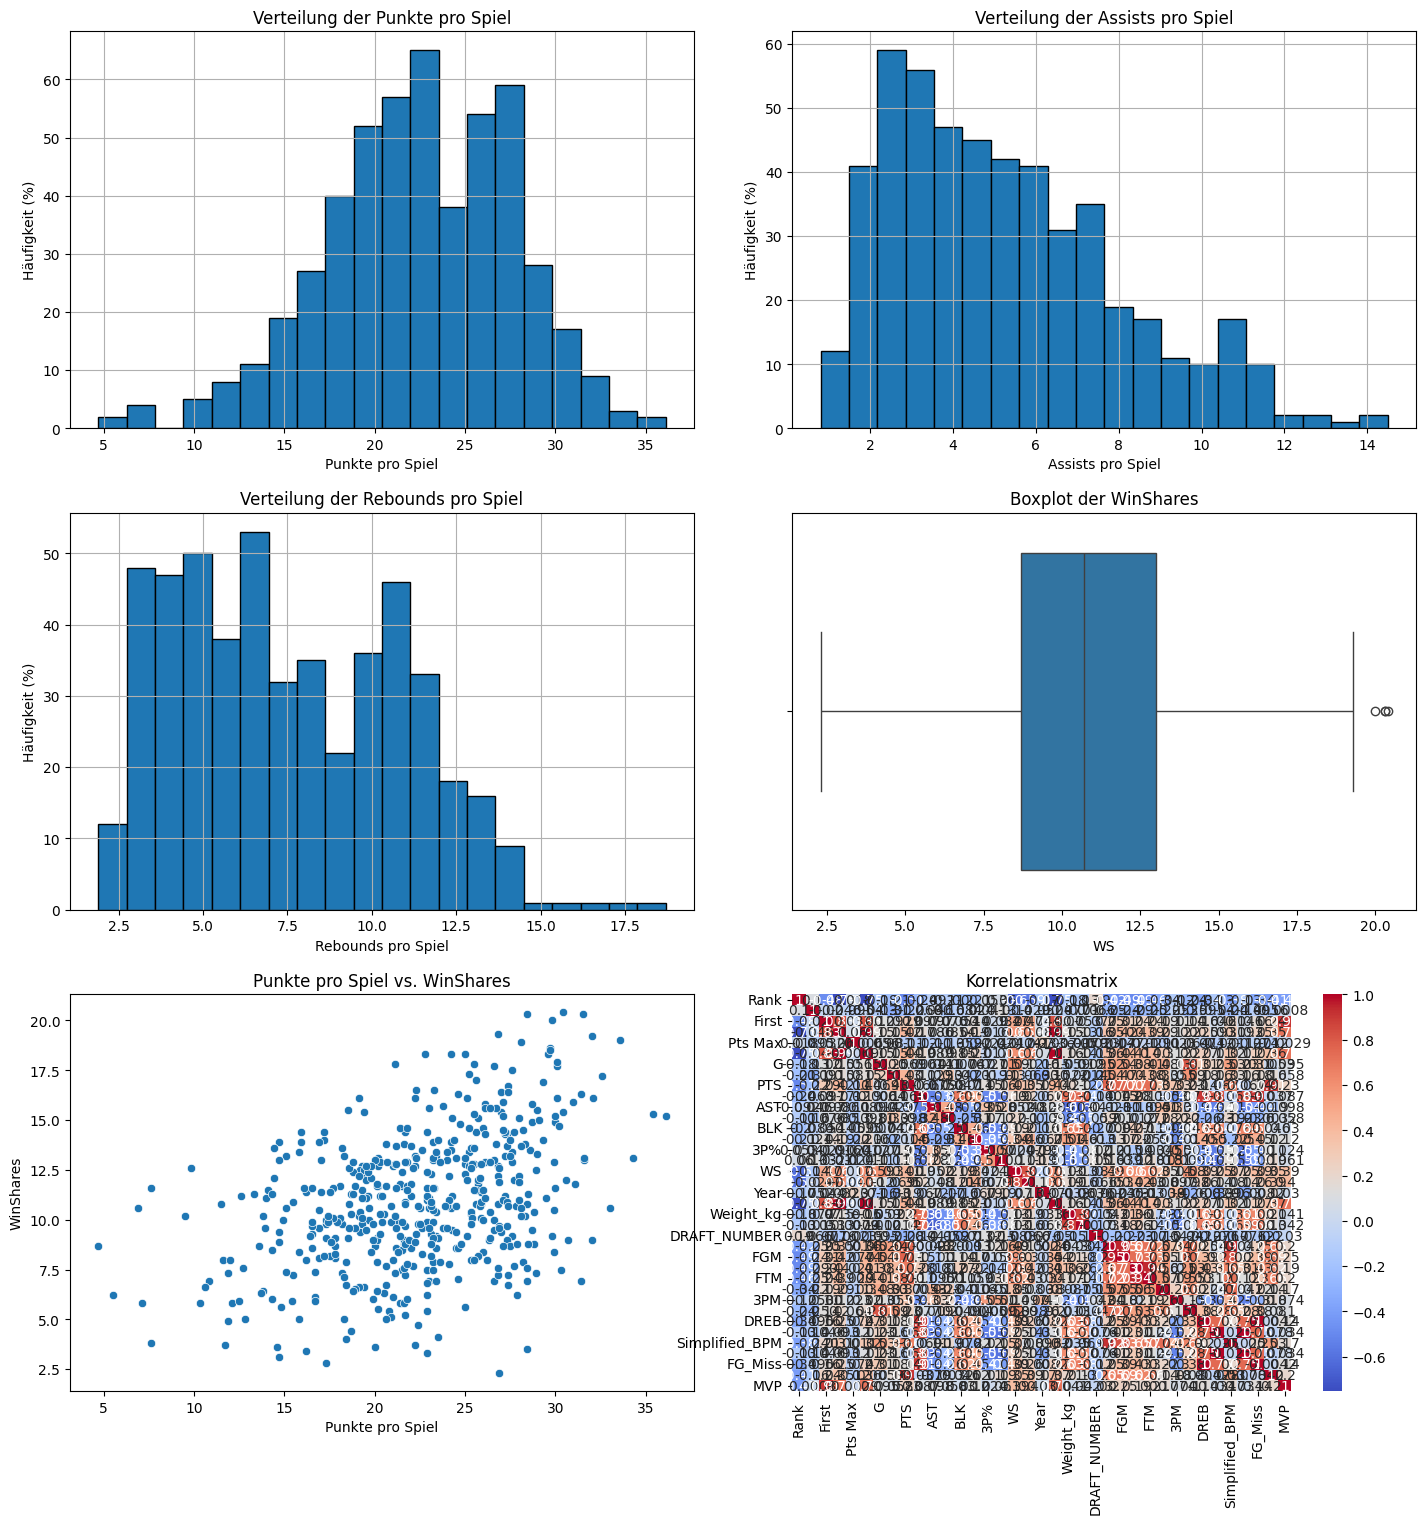

In [23]:
# Erstellen eines 3x2 Grids für die Plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))  # Größe kann nach Bedarf angepasst werden

# Anpassung des Layouts für eine bessere Anzeige
plt.tight_layout(pad=4.0)

# Histogramm der Punkte pro Spiel
mvps['PTS'].hist(bins=20, edgecolor='black', ax=axs[0, 0])
axs[0, 0].set_title('Verteilung der Punkte pro Spiel')
axs[0, 0].set_xlabel('Punkte pro Spiel')
axs[0, 0].set_ylabel('Häufigkeit (%)')

# Histogramm der Assists pro Spiel
mvps['AST'].hist(bins=20, edgecolor='black', ax=axs[0, 1])
axs[0, 1].set_title('Verteilung der Assists pro Spiel')
axs[0, 1].set_xlabel('Assists pro Spiel')
axs[0, 1].set_ylabel('Häufigkeit (%)')

# Histogramm der Rebounds pro Spiel
mvps['TRB'].hist(bins=20, edgecolor='black', ax=axs[1, 0])
axs[1, 0].set_title('Verteilung der Rebounds pro Spiel')
axs[1, 0].set_xlabel('Rebounds pro Spiel')
axs[1, 0].set_ylabel('Häufigkeit (%)')

# Boxplot zur Darstellung der Verteilung der WinShares
sns.boxplot(x='WS', data=mvps, ax=axs[1, 1])
axs[1, 1].set_title('Boxplot der WinShares')

# Scatterplot zur Visualisierung der Beziehung zwischen Punkten pro Spiel und WinShares
sns.scatterplot(x='PTS', y='WS', data=mvps, ax=axs[2, 0])
axs[2, 0].set_title('Punkte pro Spiel vs. WinShares')
axs[2, 0].set_xlabel('Punkte pro Spiel')
axs[2, 0].set_ylabel('WinShares')

# Korrelationsmatrix der numerischen Merkmale
# Auswahl nur der numerischen Spalten für die Korrelationsmatrix
numerical_cols = [col for col in mvps.columns if mvps[col].dtype != 'object' and mvps[col].dtype != 'string']
numerical_mvps = mvps[numerical_cols]
correlation_matrix = numerical_mvps.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axs[2, 1])
axs[2, 1].set_title('Korrelationsmatrix')

plt.show()


Verteilung der Punkte pro Spiel: Ein Histogramm, das die relative Häufigkeit der erzielten Punkte pro Spiel zeigt. Die meisten Werte liegen zwischen 10 und 25 Punkten, mit einem Höhepunkt zwischen 15 und 20 Punkten.

Verteilung der Assists pro Spiel: Ein weiteres Histogramm, das die Anzahl der Assists pro Spiel darstellt. Die meisten Spiele scheinen zwischen 2 und 6 Assists zu haben, mit einer Spitze bei etwa 3 bis 4 Assists.

Verteilung der Rebounds pro Spiel: Dieses Histogramm zeigt, wie häufig bestimmte Anzahlen von Rebounds pro Spiel vorkommen. Die Verteilung scheint breiter gestreut zu sein, mit den häufigsten Werten im Bereich von etwa 5 bis 10 Rebounds pro Spiel.

Boxplot der WinShares: Ein Boxplot, der die Verteilung der WinShares (WS) darstellt, ein Maß für den Beitrag eines Spielers zum Sieg seiner Mannschaft. Der Boxplot zeigt den Median, die Quartile und eventuelle Ausreißer. Hier ist zu bemerken, dass die meisten WS-Werte in einem zentralen Bereich liegen, es gibt jedoch einen Ausreißer auf der rechten Seite.

Punkte pro Spiel vs. WinShares: Ein Streudiagramm, das die Beziehung zwischen der Anzahl der Punkte pro Spiel und den WinShares zeigt. Die Punkte sind über das Diagramm verteilt, was eine Variation in der Anzahl der WinShares bei unterschiedlichen Punktzahlen pro Spiel anzeigt. Es scheint keine klare lineare Beziehung zu geben, was darauf hindeutet, dass hohe Punktzahlen pro Spiel nicht unbedingt mit hohen WinShares korrelieren.

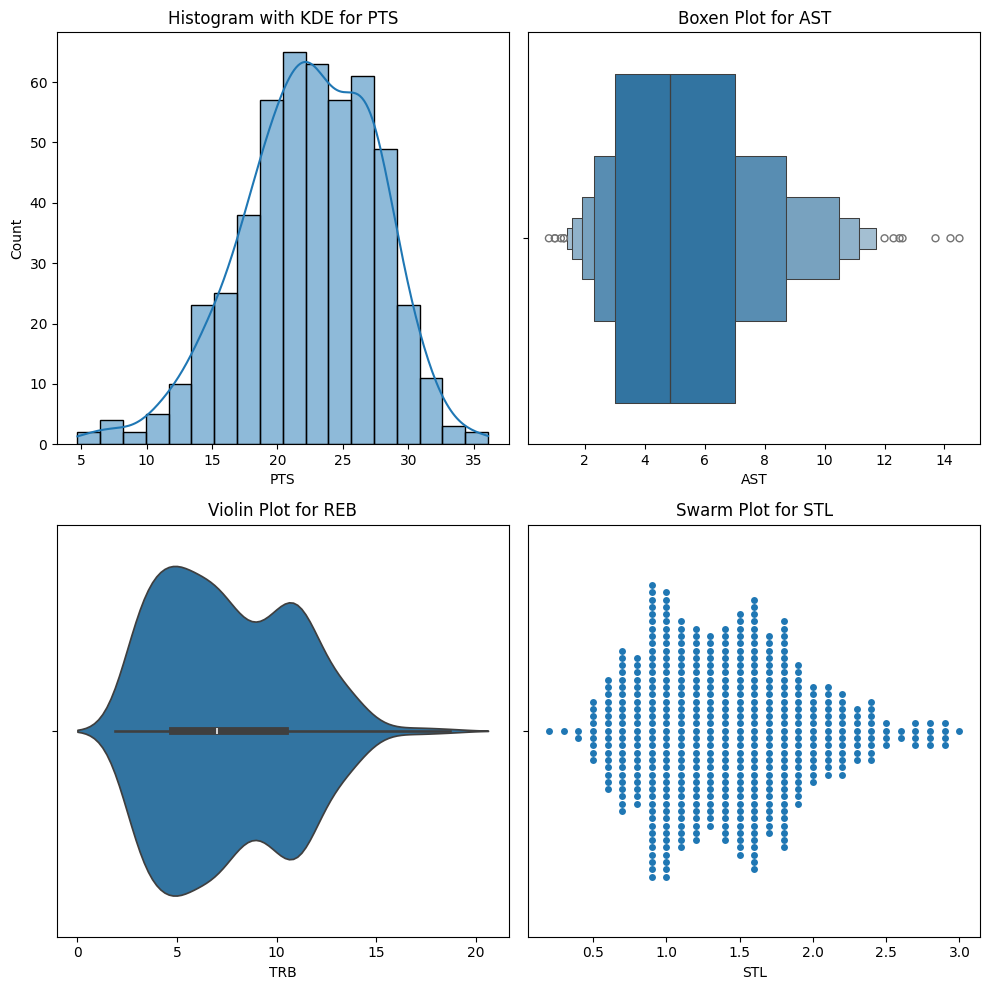

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Histogram with a fitted Kernel Density Estimate (KDE) for 'PTS'
sns.histplot(mvps['PTS'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Histogram with KDE for PTS')

# Boxen Plot for 'AST' (Assists)
sns.boxenplot(x=mvps['AST'], ax=axs[0, 1])
axs[0, 1].set_title('Boxen Plot for AST')

# Violin Plot for 'REB' (Rebounds)
sns.violinplot(x=mvps['TRB'], ax=axs[1, 0])
axs[1, 0].set_title('Violin Plot for REB')

# Swarm Plot for 'STL' (Steals)
sns.swarmplot(x=mvps['STL'], ax=axs[1, 1])
axs[1, 1].set_title('Swarm Plot for STL')

plt.tight_layout()
plt.show()

Histogram with KDE for PTS: Dieses Histogramm zeigt die Verteilung der erzielten Punkte (PTS) pro Spiel mit einer überlagerten Kernel-Dichte-Schätzung (KDE), die eine glatte, kontinuierliche Kurve der Datenverteilung darstellt. Es zeigt einen Gipfel um den Bereich von etwa 15 bis 20 Punkten.

Boxen Plot for AST: Ein Boxplot, der die Verteilung der Assists (AST) pro Spiel zeigt. Er zeigt den Median, die Quartile und eventuelle Ausreißer an, die als einzelne Punkte außerhalb des Boxenbereichs dargestellt sind. Dieser Plot verdeutlicht, dass die meisten Werte im Bereich von etwa 2 bis 6 Assists liegen.

Violin Plot for REB: Ein Violin-Plot ist ähnlich einem Boxplot, zeigt jedoch die Dichte der Daten an verschiedenen Punkten, was eine tiefere Einsicht in die Struktur der Verteilung der Rebounds (REB) gibt. Hier sieht man, dass die Dichte um die Mitte am höchsten ist, was auf eine Konzentration der Werte in diesem Bereich hindeutet.

Swarm Plot for STL: Dieser Plot zeigt die Verteilung der Steals (STL) pro Spiel als einzelne Punkte, die so angeordnet sind, dass sie nicht übereinander liegen. Dies bietet eine klare Sicht auf die Häufigkeit und Verteilung von Steals und deutet auf eine Konzentration der Werte im Bereich von etwa 0,5 bis 1,5 Steals pro Spiel hin.

In [71]:
# Check if 'Position' column exists in the DataFrame
if 'Position' in df.columns:
        # Create a DataFrame grouping the average values by position
        avg_stats_by_position = df.groupby('Position').mean()

        # Plot the average points per position
        sns.barplot(x=avg_stats_by_position.index, y='PTS', data=avg_stats_by_position)
        plt.xlabel('Position')
        plt.ylabel('Average Points')
        plt.show()
else:
        print("The 'Position' column does not exist in the DataFrame.")


KeyError: 'Position'

Wir wollten die ungefähre Beziehung zwischen dem Anteil an Auszeichnungen und bestimmten wichtigen Statistiken, von denen allgemein angenommen wird, dass sie die Abstimmungsergebnisse beeinflussen, verstehen. In den dargestellten Diagrammen kennzeichnen gelbe Punkte die Spieler, die in einem bestimmten Jahr den Titel des wertvollsten Spielers (MVP) erhalten haben.

#### (5) Verwendung eines ML Frameworks/Library (tensorflow/keras, sklearn oder im Kurs nicht betrachtete wie pytorch)

#### (6) Erstellen von Modellvorhersagen

In [27]:
def calculate_ml_scores(df):
    X = df.copy()
    y = X["Share"]

    X.drop('Share', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores



In [28]:
#drop columns for mutual information
to_drop_mi = ['Rank','Player','Share', 'MVP', 'Nationality', 'Position', 'First', 'Pts Won']
master_table_mi = mvps.copy()
master_table_mi.drop(to_drop_mi, axis=1, inplace=True)
master_table_mi = master_table_mi.fillna(0)

In [29]:
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)

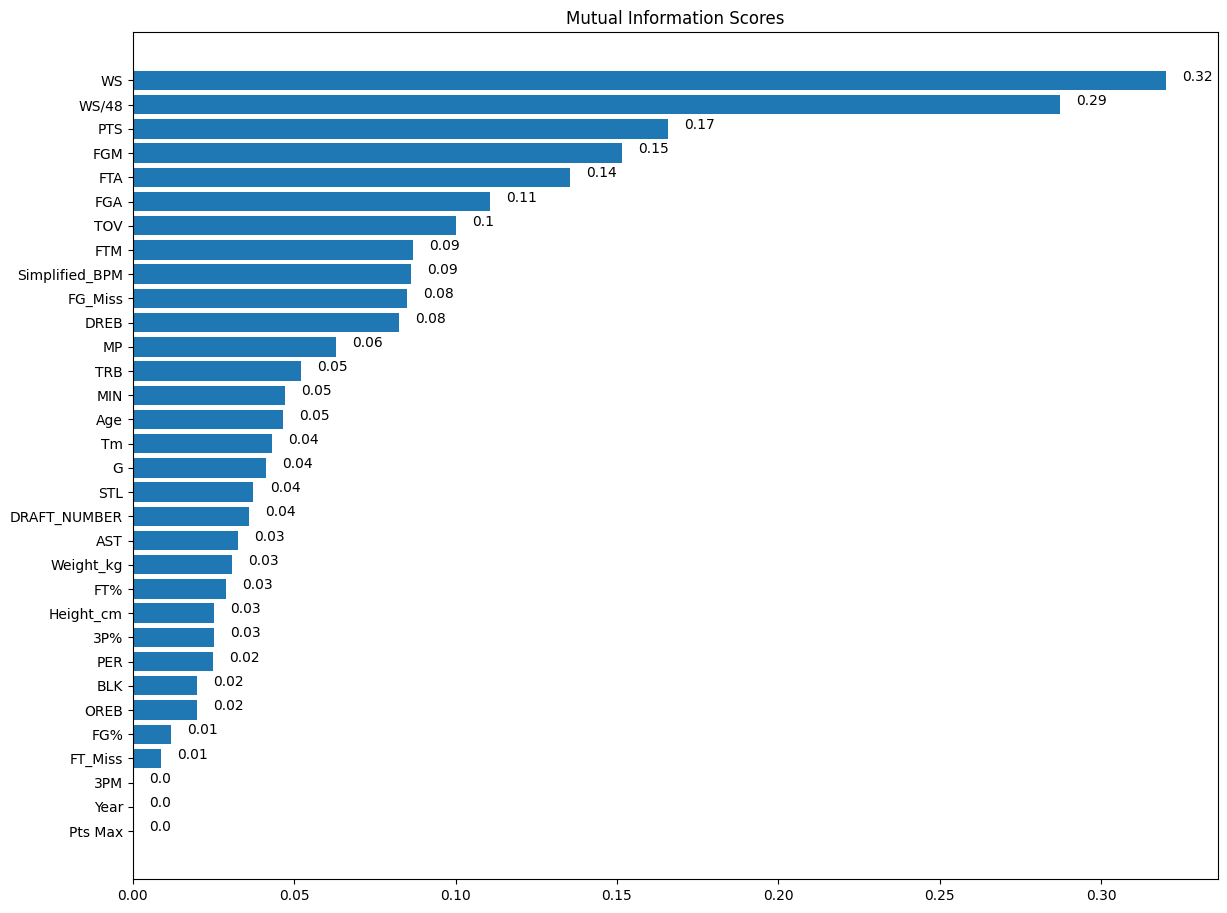

In [30]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores, figsize=(14,11))

In [31]:
import plotly.express as px
def show_feature_vs_share(feature, df):
    fig = px.scatter(data_frame = df,
               x=feature,
               y='Share',
               color='MVP',
               color_discrete_sequence=['blue','gray'], 
               hover_data={
                   'Player': True, 
                   'Year': True
                   
               })
    fig.update_layout(height=500,
                     title = f"{feature} vs. MVP share")
    fig.show()

In [32]:
features = ['WS', 
            'WS/48',
            'PTS',
            'FGM']

for feature in features:
    show_feature_vs_share(feature=feature, df=mvps)

In [33]:

to_drop = [
    #'Year',
    '3PM',
    'OREB',
    'FG%',
    'Pts Max',
    'Age',
    '3P%',
    'PER',
    'STL',
    'Height_cm',
    'FT%',
    'Weight_kg',
    'BLK',
    'G',
    'AST',
    'MIN',
    'TRB',
    'Tm',
    'DRAFT_NUMBER',
    'MP',
    'Rank',
    'Player',
    'MVP', 
    'Year',
    'Nationality', 
    'Position', 
    'First', 
    'Pts Won',
    'FT_Miss'
]

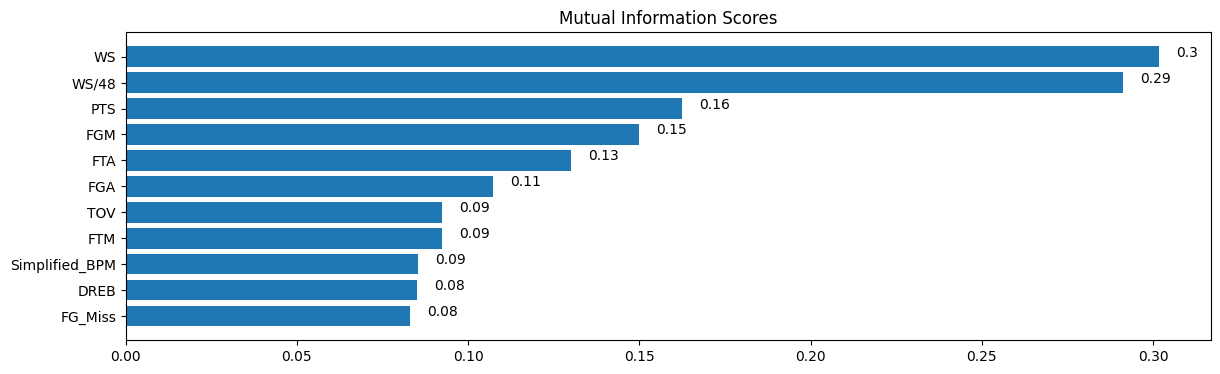

In [34]:
mvps_mod = mvps.copy()
mvps_mod.drop(to_drop, axis=1, inplace=True)
X, y, mi_scores2 = calculate_ml_scores(df=mvps_mod)
plot_mi_scores(mi_scores2, figsize=(14,4))

#### Train/Test Split
test on selected year, train on all other years that weren't selected

In [35]:
def train_test_split_by_year(year, df, scaling=False):
    #test year = selected year, train year = other years outside of selected year
    train_df = df[df['Year'] != year]
    test_df = df[df['Year'] == year]
    
    train_df2 = train_df.copy()
    test_df2 = test_df.copy()
    
    train_df2.drop(to_drop, axis=1, inplace=True)
    test_df2.drop(to_drop, axis=1, inplace=True)
    
    if scaling == True:
        sc_X = StandardScaler()
        sc_y = StandardScaler()
        train_df2 = sc_X.fit_transform(train_df2)
        test_df2 = sc_y.fit_transform(test_df2)
    
    X_train = train_df2.copy()
    y_train = X_train["Share"]
    
    X_test = test_df2.copy()
    y_test = X_test["Share"]

    X_train.drop('Share', axis=1, inplace=True)
    cols = X_train.columns
    X_test.drop('Share', axis=1, inplace=True)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test, cols

#### Model Helper Functions
train, predict, calculate MAE & R squared, show actual vs. predicted in a dataframe

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def run_model(regressor, X_train, y_train, X_test, y_test, df, year):
    model = regressor
    model.fit(X_train, y_train) 
    predictions = model.predict(X_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r2_score(y_test, predictions)
    
    mvp_race = df[df['Year'] == year]
    mvp_race['predicted_share'] = predictions
    mvp_race = mvp_race.sort_values(["Share", "predicted_share"], ascending = (False, False))
    #print("RACE", mvp_race)                               
    
    actual_winner = mvp_race[mvp_race['MVP'] == 1]['Player']
    
    predicted_winner = mvp_race[mvp_race['predicted_share'] == mvp_race['predicted_share'].max()]['Player']
    
    actual_winner_name = actual_winner.iloc[0] if not actual_winner.empty else None
    predicted_winner_name = predicted_winner.iloc[0] if not predicted_winner.empty else None
    #print(year)
    #print("act", actual_winner_name)
    #print("pred", predicted_winner_name)
    return model, mae, r2, predicted_winner_name, actual_winner_name, mvp_race
    

In [37]:
years = list(range(1990, 2022))

def run_model_average(df, regressor, scaling=False, print_metrics=False):
    mae_lst = []
    r2_lst = []
    predicted_lst = []
    actual_lst = []
    label_lst =[]
    model_lst = []
    for year in years:
        X_train, y_train, X_test, y_test, cols = train_test_split_by_year(year=year, df=df, scaling=False)
        model, mae, r2, predicted_winner, actual_winner, mvp_race = run_model(regressor,
        X_train,
        y_train,
        X_test,
        y_test,
        df=df,
        year=year
        )
        label = 'correct' if predicted_winner == actual_winner else 'incorrect'
        mae_lst.append(mae)
        r2_lst.append(r2)
        predicted_lst.append(predicted_winner)
        actual_lst.append(actual_winner)
        label_lst.append(label)
        model_lst.append(model)
    d = {
    'year': years,
    'MAE': mae_lst,
    'R squared': r2_lst,
    'Predicted MVP': predicted_lst,
    'Actual MVP': actual_lst,
    'Label': label_lst
    }
    print('d=', d)
    summary = pd.DataFrame(d)
    correct_count = summary['Label'].value_counts().iloc[0]
    incorrect_count = summary['Label'].value_counts().iloc[1]
    accuracy = correct_count / (correct_count + incorrect_count)
    avg_mae = summary['MAE'].mean()
    avg_r2  = summary['R squared'].mean()

    if print_metrics == True:
        print(f"Average MAE: {avg_mae}")
        print(f"Average R squared: {avg_r2}")
        print(f"Prediction accuracy: {accuracy}")
    return avg_mae, avg_r2, accuracy, summary, model_lst, cols

    

find average metrics and overall accuracy

In [38]:
pd.options.mode.chained_assignment = None

lr_avg_mae, lr_avg_r2, lr_accuracy, lr_summary, lr_models, cols = run_model_average(df=mvps,
    regressor = LinearRegression(),
    scaling=True,
    print_metrics=True)

d= {'year': [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'MAE': [0.16531810970776278, 0.13313439917652417, 0.10810313892341396, 0.14657041970842855, 0.1424450555594821, 0.17183682057303262, 0.12957134601351505, 0.1336794771737282, 0.13126052099828742, 0.19769328894897734, 0.10532498059075507, 0.16528713346292853, 0.17971917388549505, 0.16425920829902066, 0.1346598315375038, 0.22270169605933932, 0.16598775433127508, 0.15287048607014114, 0.1701589689723666, 0.142598937353645, 0.1404188202215795, 0.13907200548176285, 0.16373816283718115, 0.1275211754611908, 0.1693946301152805, 0.13961379590416292, 0.2042619303150547, 0.19945557208724704, 0.16186931889481462, 0.17527567475641814, 0.1607988123502623, 0.16619068315497498], 'R squared': [0.4683226108288129, 0.5727820149326397, 0.5997838106492587, 0.571736020510035, 0.5438890206767737, 0.386570227

Random Forest Regressor

In [39]:
#display feature importance for tree algorithms (RF, XGB, LGBM
def avg_feature_importance(models, cols):
    lst = []
    for model in models:
        feature_importance = list(model.feature_importances_)
        lst.append(feature_importance)
        
    df = pd.DataFrame(lst, columns=cols)
    mean_features = df.mean()
    
    #df2 = pd.DataFrame([cols ,mean_features], columns=['Feature', 'Feature Importance'])
    df2 = pd.DataFrame([cols ,mean_features]).T
    df2 = df2.rename(columns={0:'Feature', 1:'Score'}).sort_values(by='Score', ascending=False)
    
    #plt.rcParams["figure.figsize"] = (7,4)
    plt.title('Feature Importance Score')
    sns.barplot(x='Score',
                y= 'Feature',
                data=df2,
                )
    plt.show()

In [40]:
rf_avg_mae, rf_avg_r2, rf_accuracy, rf_summary, rf_models, rf_cols = run_model_average(df=mvps,
    regressor=RandomForestRegressor(n_estimators = 23, 
                                                random_state = 0, 
                                                max_depth=7, 
                                                min_samples_leaf=1,
                                                min_samples_split=2),
                                                print_metrics=True)

d= {'year': [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'MAE': [0.14324924794036448, 0.08468297023077336, 0.08018892280440784, 0.16786249062002878, 0.10990596769721918, 0.08917374488667629, 0.08264388772487158, 0.06517934871662225, 0.1043387688783561, 0.12447017757408155, 0.07764626360088836, 0.17028899824973845, 0.1477933312996519, 0.19381453832774903, 0.11378866298692185, 0.21029887300849184, 0.23652825860169926, 0.10226658693882357, 0.1298206304571825, 0.12038503107471944, 0.08900887520979284, 0.1449748359916409, 0.14685629066082279, 0.08891034284146415, 0.11038181321923744, 0.12793353550046874, 0.22145887898846336, 0.20403615846525405, 0.10373521241388238, 0.10341524488216321, 0.16892951786670918, 0.11383157830877073], 'R squared': [0.5220974958932392, 0.7643687972337716, 0.7170697656642055, 0.2765984622299468, 0.5478499299874175, 0.7

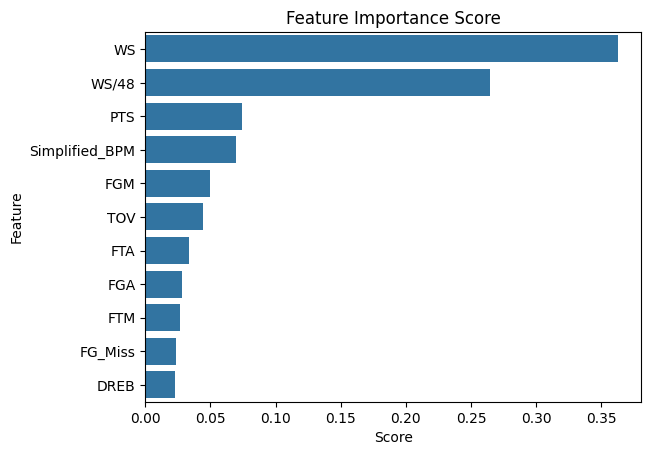

In [41]:
avg_feature_importance(models=rf_models, cols=rf_cols)

#### Forecast this Seasons MVP

Get Data

WS/48 not yet available!

In [42]:
# Fetch player stats for the current season (replace '2023-24' if necessary)
player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24')


# Get a DataFrame of the stats
df_player_stats = player_stats.get_data_frames()[0]
df_player_stats = df_player_stats[df_player_stats['GP'] >= 65] #Players must have played at least 65 Games to be considered beginning this season


df_player_stats['TRB'] = df_player_stats['OREB'] + df_player_stats['DREB']
df_player_stats['TRB'] = pd.to_numeric(df_player_stats['TRB'], errors='coerce')
df_player_stats['Simplified_BPM'] = ((df_player_stats['PTS'] + 0.5 * df_player_stats['TRB'] + df_player_stats['AST'] + 2 * (df_player_stats['STL'] + df_player_stats['BLK'])
                          - (df_player_stats['FGA'] - df_player_stats['FGM']) - 0.5 * (df_player_stats['FTA'] - df_player_stats['FTM']) - df_player_stats['TOV']) / (df_player_stats['MIN']/df_player_stats['GP'])) 



df_player_stats['FT_Miss'] = df_player_stats['FTA'] - df_player_stats['FTM']
df_player_stats['FG_Miss'] = df_player_stats['FGA'] - df_player_stats['FGM']



# Specify the columns you need, based on the mutual information scores chart
selected_columns = [
    'PLAYER_NAME',
    'PTS',  # Points
    'W_PCT',  # Field Goals Made
    'FGA',  # Field Goals Attempted
    'FGM',  # Three Point Field Goals Made, if available
    'FTA',  # Three Point Field Goals Attempted, if available
    'FTM',  # Free Throws Made
    'TOV',  # Turnovers
    'DREB',  # Offensive Rebounds
    'Simplified_BPM', 
    'FG_Miss'
]

# Filter the DataFrame to only include the selected columns
df_selected_stats = df_player_stats[selected_columns]





# Display the DataFrame with the selected columns
#print(df_selected_stats.head())
print(df_player_stats['Simplified_BPM'])


3      37.957499
4      30.733447
5      33.313132
6      38.674589
11     27.433626
         ...    
550    42.992750
551    38.674543
555    64.167789
566    36.812073
571    50.605231
Name: Simplified_BPM, Length: 177, dtype: float64


In [43]:
def prep_train_test(df):
    
    forecast_X_train_df = df.copy()
    forecast_X_train_df.drop(to_drop, axis=1, inplace=True)
    forecast_y_train_df = forecast_X_train_df['Share']
    forecast_X_train_df.drop(['Share'], axis=1, inplace=True)
    
    
    forecast_X_test_df = df_selected_stats_cleaned
    
    print(f'Training dataset columns: \n{list(forecast_X_train_df.columns)} \n')
    print(f'Forecasting dataset columns: \n{list(forecast_X_test_df.columns)}')
    return forecast_X_train_df, forecast_y_train_df, forecast_X_test_df

In [44]:
def fit_forecast_model(regressor):
    model = regressor
    model.fit(forecast_X_train_df, forecast_y_train_df) 
    predictions = model.predict(forecast_X_test_df)
    
    mvp_race_forecast = df_selected_stats.copy()
    mvp_race_forecast['Share Prediction'] = predictions
    mvp_race_forecast = mvp_race_forecast.sort_values(["Share Prediction"], ascending = (False))
    
    mvp_race_forecast_sub = mvp_race_forecast[[
                                                'Player',
                                                'Share Prediction',
                                                'WS',
                                                'PTS',
                                                'Simplified_BPM',
                                                'TOV',
                                                'FGM',
                                                'FTA',
                                                'FTM',
                                                'FG_Miss',
                                                'DREB'
                                              ]].reset_index(drop=True)
    mvp_race_forecast_sub.head()
    avg_feature_importance(models=[model], cols=df_selected_stats_cleaned.columns)
    return model, mvp_race_forecast_sub

In [45]:
def show_highlighted_df(df):
    return df.style.highlight_max(subset = [        'WS',
                                                    'PTS',
                                                    'Simplified_BPM',
                                                    'TOV',
                                                    'FGM',
                                                    'FTA',
                                                    'FTM',
                                                    'FG_Miss',
                                                    'DREB',
                                                    'Share Prediction'], color = 'lightgreen', axis = 0)

In [46]:
mvps2 = mvps.copy()
mvps2.drop('WS/48', axis=1, inplace=True)
df_selected_stats.rename(columns={'W_PCT': 'WS'}, inplace=True)
df_selected_stats.rename(columns={'PLAYER_NAME': 'Player'}, inplace=True)

needed_cols = ['PTS', 'WS', 'FGA', 'FGM', 'FTA', 'FTM', 'TOV', 'DREB', 'Simplified_BPM', 'FG_Miss'] 
df_selected_stats_cleaned = df_selected_stats[list(needed_cols)]


forecast_X_train_df, forecast_y_train_df, forecast_X_test_df = prep_train_test(df=mvps2)

Training dataset columns: 
['PTS', 'WS', 'FGA', 'FGM', 'FTA', 'FTM', 'TOV', 'DREB', 'Simplified_BPM', 'FG_Miss'] 

Forecasting dataset columns: 
['PTS', 'WS', 'FGA', 'FGM', 'FTA', 'FTM', 'TOV', 'DREB', 'Simplified_BPM', 'FG_Miss']


#### (8) Korrekte Interpretation der Modellergebnisse und Modellgütemasse

In [47]:
n_estimator_lst = [11,12,13,14,15,16]
max_depth_lst = [10,11,12]
min_samples_leaf_lst = [1]
min_samples_split_lst = [2]

def find_best_parameter_rf(df): 
    avg_mae_lst = []
    avg_r2_lst = []
    avg_accuracy_lst = []
    summary_lst = []

    ex_n_estimator_lst = []
    ex_max_depth_lst = []
    ex_min_samples_leaf_lst = []
    ex_min_samples_split_lst = []

    for i in n_estimator_lst:
        for j in max_depth_lst:
            for x in min_samples_leaf_lst:
                for y in min_samples_split_lst:
                    mae, r2, accuracy, summary, models, cols = run_model_average(df=df,
                          regressor=RandomForestRegressor(n_estimators = i,
                                                          random_state = 0,
                                                          max_depth=j,
                                                          min_samples_leaf=x,
                                                          min_samples_split=y
                                                         ),
                print_metrics=False)
                    avg_mae_lst.append(mae)
                    avg_r2_lst.append(r2)
                    avg_accuracy_lst.append(accuracy)
                    summary_lst.append(summary)

                    ex_n_estimator_lst.append(i)
                    ex_max_depth_lst.append(j)
                    ex_min_samples_leaf_lst.append(x)
                    ex_min_samples_split_lst.append(y)

    d = {
        'n_estimator': ex_n_estimator_lst,
        'max_depth': ex_max_depth_lst,
        'min_samples_leaf': ex_min_samples_leaf_lst, 
        'min_samples_split': ex_min_samples_split_lst, 
        'MAE': avg_mae_lst,
        'r2': avg_r2_lst,
        'Accuracy': avg_accuracy_lst,
    }
    
    #sort by highest accuracy, then highest r squared
    df = pd.DataFrame(d).sort_values(["Accuracy", "r2"], ascending = (False, False))
    return df

In [48]:
rf_parameter_options = find_best_parameter_rf(df=mvps)

d= {'year': [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'MAE': [0.15104690360998105, 0.09907895293629765, 0.10895013827880988, 0.1492502931997695, 0.10513942158286278, 0.10350341896423526, 0.09050700339258075, 0.0806654672033498, 0.09533194027319503, 0.11968835556458875, 0.0964866464078399, 0.17610764064909684, 0.135952300384501, 0.22079715849424014, 0.12752194052588883, 0.27441921426870414, 0.24064206066418567, 0.10722611621308542, 0.1592170541269121, 0.13101748599141674, 0.13230199311271743, 0.17055426435498322, 0.14034974542864223, 0.12510990598986477, 0.133724917096858, 0.13326007701878376, 0.2541288784769118, 0.20940406376438447, 0.11949933520368541, 0.13220976248129448, 0.17907412708664616, 0.14406908415812592], 'R squared': [0.34413444951715244, 0.7028850580603941, 0.5383777798688152, 0.37680299862441613, 0.600603873645074, 0.70182

In [49]:
rf_parameter_options.head()

,n_estimator,max_depth,min_samples_leaf,min_samples_split,MAE,r2,Accuracy
1,11,11,1,2,0.145780,0.343608,0.62500
16,16,11,1,2,0.143573,0.369714,0.59375
13,15,11,1,2,0.144189,0.365372,0.59375
10,14,11,1,2,0.144424,0.361678,0.59375
7,13,11,1,2,0.144273,0.361541,0.59375


In [50]:
rf_best_parameters = dict(rf_parameter_options.iloc[0][:5])
rf_best_parameters

{'n_estimator': 11.0,
 'max_depth': 11.0,
 'min_samples_leaf': 1.0,
 'min_samples_split': 2.0,
 'MAE': 0.145780453395523}

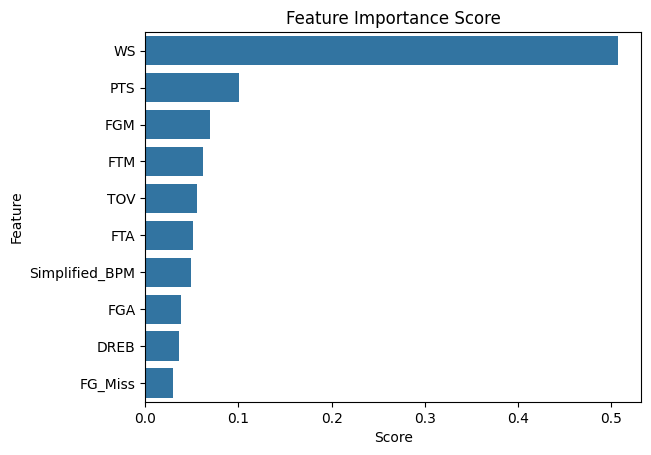

In [51]:

#best random forest model
rf_model, rf_mvp_race_forecast = fit_forecast_model(regressor = RandomForestRegressor(
                                                    n_estimators = 11, 
                                                    random_state = 42, 
                                                    max_depth=11, 
                                                    min_samples_leaf=1,
                                                    min_samples_split=2)
)

In [52]:
show_highlighted_df(df=rf_mvp_race_forecast.head(10))


,Player,Share Prediction,WS,PTS,Simplified_BPM,TOV,FGM,FTA,FTM,FG_Miss,DREB
0,Nikola Jokic,0.493664,0.701000,2048,78.047953,230,806,433,354,581,737
1,Domantas Sabonis,0.452485,0.570000,1532,62.180345,262,610,401,281,418,801
2,Anthony Edwards,0.439333,0.688000,2022,51.324803,233,711,492,410,828,369
3,Damian Lillard,0.433727,0.667000,1759,47.076092,191,539,501,461,724,281
4,Anthony Davis,0.409545,0.581000,1810,65.166175,152,689,495,404,555,705
5,Jayson Tatum,0.402364,0.781000,1969,52.569430,186,667,488,407,746,531
6,Jalen Brunson,0.401818,0.622000,2103,52.620296,180,751,473,400,819,226
7,Brook Lopez,0.394455,0.623000,961,41.776549,78,355,130,106,377,291
8,Brandin Podziemski,0.394455,0.549000,661,32.239555,87,262,78,49,315,294
9,Royce O'Neale,0.394455,0.468000,598,32.674181,72,211,33,23,318,312
